In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sentence_transformers import SentenceTransformer
from tqdm import tqdm

sns.set(style="whitegrid", context="notebook")
tqdm.pandas()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Cargar el dataset preprocesado
df = pd.read_csv("/content/drive/Shareddrives/IBD-NLP-RiskPrediction_data/Reddit/processed/reddit_ibd_preprocessed.csv")

print("Dimensiones del dataset:", df.shape)
df.head(2)

Dimensiones del dataset: (183744, 14)


,id,subreddit,author,title,selftext,created_utc,comments,cuerpo,title_clean,title_lemma,selftext_clean,selftext_lemma,comments_clean,comments_lemma
0,dflwn,CrohnsDisease,zakool21,Don't be afraid of diagnostic procedures....,"I'm not likely to frontpage this subreddit, bu...",2010-09-18 11:59:11,"['I have to agree, the worse part of a Colonos...",TÍTULO:\nDon't be afraid of diagnostic procedu...,do not be afraid of diagnostic procedures,afraid diagnostic procedure,i am not likely to frontpage this subreddit bu...,likely frontpage subreddit glad exist want rea...,i have to agree the worse part of a colonoscop...,agree bad colonoscopy prep glad ok case thank ...
1,dfyy1,CrohnsDisease,sphinctersayzwha,Mayo Clinic article on Crohn's Disease.,Mayo Clinic article on Crohn's Disease.,2010-09-19 15:11:21,[],TÍTULO:\nMayo Clinic article on Crohn's Diseas...,mayo clinic article on crohn s disease,mayo clinic article crohn s disease,mayo clinic article on crohn s disease,mayo clinic article crohn s disease,NaN,NaN


In [4]:
texts = df["selftext_lemma"].fillna("")
print(f"Número de textos cargados: {len(texts)}")

Número de textos cargados: 183744


### Representación mediante TF-IDF

In [5]:
vectorizer = TfidfVectorizer(
    max_features=5000,       # límite de palabras o n-gramas
    ngram_range=(1,2),       # unigramas y bigramas
    min_df=3,                # palabras que aparezcan al menos en 3 documentos
    stop_words='english'
)

X_tfidf = vectorizer.fit_transform(texts)
print("Forma de la matriz TF-IDF:", X_tfidf.shape)

Forma de la matriz TF-IDF: (183744, 5000)


In [6]:
# Palabras más representativas según TF-IDF
feature_names = vectorizer.get_feature_names_out()
tfidf_sum = np.array(X_tfidf.sum(axis=0)).flatten()

tfidf_df = pd.DataFrame({
    "term": feature_names,
    "weight": tfidf_sum
}).sort_values(by="weight", ascending=False)

tfidf_df.head(15)

,term,weight
1154,delete,16276.795424
3615,remove,5284.890963
2513,like,4389.282561
1627,feel,4325.638490
1068,day,4145.647037
4427,time,3775.397834
4942,year,3669.648561
3138,pain,3668.444909
2394,know,3649.623851
4795,week,3535.540352


/tmp/ipython-input-69777070.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tfidf_df.head(20), x="weight", y="term", palette="viridis")


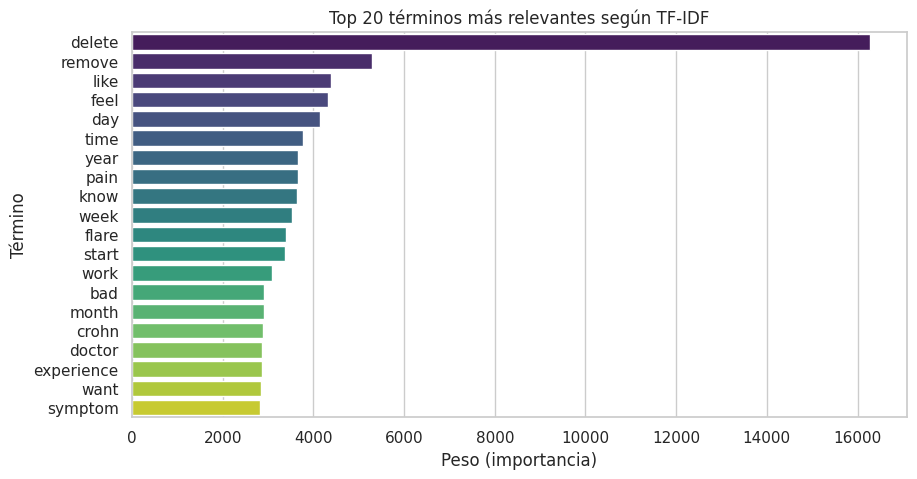

In [7]:
plt.figure(figsize=(10,5))
sns.barplot(data=tfidf_df.head(20), x="weight", y="term", palette="viridis")
plt.title("Top 20 términos más relevantes según TF-IDF")
plt.xlabel("Peso (importancia)")
plt.ylabel("Término")
plt.show()

### Representación mediante Sentence-BERT

In [8]:
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [9]:
embeddings = model.encode(texts.tolist(), show_progress_bar=True)
print("Forma de la matriz de embeddings:", embeddings.shape)

Batches:   0%|          | 0/5742 [00:00<?, ?it/s]

Forma de la matriz de embeddings: (183744, 384)


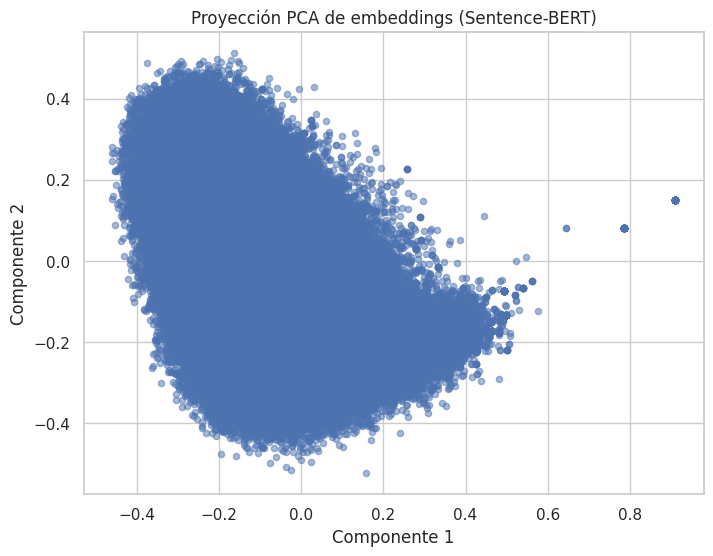

In [10]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(embeddings)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5, s=20)
plt.title("Proyección PCA de embeddings (Sentence-BERT)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()

In [12]:
import numpy as np

# TF-IDF
np.save("/content/drive/Shareddrives/IBD-NLP-RiskPrediction_data/Reddit/processed/X_tfidf.npy", X_tfidf.toarray())

# Embeddings
np.save("/content/drive/Shareddrives/IBD-NLP-RiskPrediction_data/Reddit/processed/X_embeddings.npy", embeddings)

print("✅ Representaciones guardadas en /content/drive/Shareddrives/IBD-NLP-RiskPrediction_data/Reddit/processed/")

✅ Representaciones guardadas en /content/drive/Shareddrives/IBD-NLP-RiskPrediction_data/Reddit/processed/
